# Работа с .csv файлами

Рассмотрим обработку однотипных экспериментальных результатов. 

Сгененрируем словарь с данными и на его основе запишем несколько схожих файлов, названия которых будут меняться в f-строке. Температура `T` и напряжение `U` будут иметь фиксированный набор значений, а значения тока `I` будут генерироваться рандомным образом в пределах от 0 до $10\cdot \mathrm{I^{0.5}}$.  

Файлы с таким типом названий чаще всего возникают при повторяющихся экспериментах, или, когда один из парметров эксперимента последовательно изменяется.

In [3]:
from random import randint
import pandas as pd

In [4]:
for i in range(3):
    data = {'T': [300, 300, 300, 250, 250, 220, 200, 200, 200, 150, 150, 150, 150, 100],
            'U': list(range(14)),
            'I': [randint(0, int(pow(j*10, 0.5))) for j in range(14)]}
    pd.DataFrame(data).to_csv(f'Data_{i+1}.csv', index=False, mode='w')

Куда интереснее перейти к чтению такой последовательности. Предположим,что были проведены несколько измерений при равных параметрах, но в разное время. От нас требуется вычислить среднее значение тока, определить разброс значений тока для каждой группы параметров с одинаковыми значениями температуры и напряжения.<br>

Задача облегчается тем, что и температура, и напряжения в каждом файле одинаковы. Есть 2 глобальных подхода: сначала читать все файлы и объединить их в один df, и уже после обрабатывать; или читать и обрабатывать файлы поотдельности, после чего сводить к одному. Выбор зависит и от данных, и от задачи - сделайте его сами.

Пример группы данных: 

`T = 1, U = 1 => I = [1,2,3,4]`

`T = 1, U = 2 => I = [4,4,4,4]`

Независимо от выбора, нам понадобится блок чтения файлов, блок разбиения по группам и вычисления требуемых величин. Отработаем их для первого файла в виде отдельных функций, принимающих DataFrame.

Мы сделаем вариант чтения одного файла, понимая, как перейти от него к  последовательной работе со всеми файлами. 

In [8]:
def read_csv(file_name: str):
    return pd.read_csv(file_name + '.csv', skip_blank_lines=True, encoding='utf-8')

Получив группы, можем вычислить среднее значение и разброс значений тока, но подход к этому зависит от выбранного пути реализации: <br>
1) Если работать с общим файлом, то сразу можно получить требуемые значения
2) В ином случаи лучше получать компоненты для вычисления средного значения (сумма элементов и их количество), а уже после этими параметрами проводить операции итогового рассчёта<br>

Предлагаем, вам реализовать свои подходы самостоятельно.

In [11]:
for i in range(3):
    df = read_csv(f'Data_{i+1}') if i == 0 else pd.concat([df, read_csv(f'Data_{i+1}')], ignore_index=True)

group = df.groupby(['T', 'U'])
answer_1 = group.mean().rename(columns={'I': 'mean'})
answer_2 = group.max() - group.min()

answer_1 = answer_1.assign(dif=answer_2['I'])
answer_1

mean  dif
T   U                
100 13  6.333333    8
150 9   3.000000    2
    10  5.666667   10
    11  6.000000    8
    12  2.666667    8
200 6   3.333333    7
    7   3.666667    4
    8   6.666667    1
220 5   4.666667    4
250 3   1.000000    2
    4   4.333333    2
300 0   0.000000    0
    1   0.666667    1
    2   2.333333    1

Нельзя не попробовать второй способ🙃

In [12]:
def read_csv(file_name: str):
    return pd.read_csv(file_name + '.csv', skip_blank_lines=True, encoding='utf-8')

for i in range(3):
    group = read_csv(f'Data_{i+1}').groupby(['T', 'U'])
    answer = group.count().rename(columns={'I': 'count'})
    answer = answer.assign(sum=group.sum())
    answer = answer.assign(max=group.max())
    answer = answer.assign(min=group.min())

    if i == 0:
        result = answer
    else:
        result['count'] += answer['count'] 
        result['sum'] += answer['sum']
        result['max'] = answer['max'].combine(result['max'], lambda x, y: max(x, y))
        result['min'] = answer['min'].combine(result['min'], lambda x, y: min(x, y))

result['mean'] = result.apply(lambda row: row['sum'] / row['count'], axis=1)
result['dif'] = result.apply(lambda row: row['max'] - row['min'], axis=1)
result

count  sum  max  min      mean   dif
T   U                                       
100 13      3   19   11    3  6.333333   8.0
150 9       3    9    4    2  3.000000   2.0
    10      3   17   10    0  5.666667  10.0
    11      3   18   10    2  6.000000   8.0
    12      3    8    8    0  2.666667   8.0
200 6       3   10    7    0  3.333333   7.0
    7       3   11    5    1  3.666667   4.0
    8       3   20    7    6  6.666667   1.0
220 5       3   14    6    2  4.666667   4.0
250 3       3    3    2    0  1.000000   2.0
    4       3   13    5    3  4.333333   2.0
300 0       3    0    0    0  0.000000   0.0
    1       3    2    1    0  0.666667   1.0
    2       3    7    3    2  2.333333   1.0

Вариант с обработкой сразу более дружелюбен при работе с огромными файлами, а также позволяет обрабатывать данные по ходу эксперимента! Во время экзамена можно применять любой подход, но последний ценится больше.

##### Еще некоторые функции полезные для полусеместрового контроля:

Построение простого графика. Нам понадобяться одинаковые по длинне массивы `x` и `y`

In [1]:
x = list(range(1, 11))
y = [i*i for i in x]

print(f'x = {x}\n',
      f'y = {y}')

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
 y = [1, 4, 9, 16, 25, 36, 49, 64, 81, 100]


Теперь передадим их в функцию `plt.plot(x, y)`

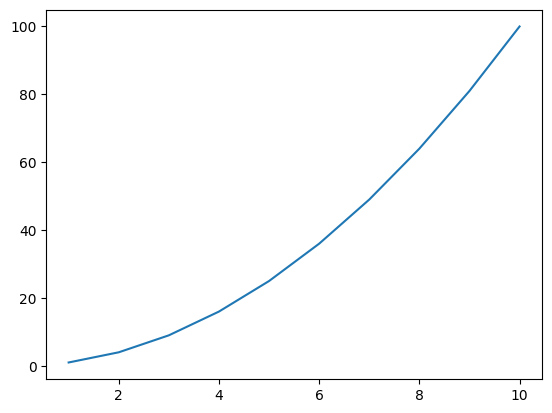

In [2]:
import matplotlib.pyplot as plt

plt.plot(x, y)

В задаче понадобится вычислить логарифм от чисел по некоторому основанию, для этого есть несколько вариантов:

1) Импортировать стандартную функцию `math.log(Number, Base)`

In [8]:
import math

math.log(8, 2)

3.0

2) Использовать стороннюю функцию, работающую с целыми массивами `np.emath.logn(Base, Numbers)`

In [11]:
import numpy as np

print(np.emath.logn(2, 8))
print(np.emath.logn([2, 4, 6], [16, 16, 36]))

3.0
[4. 2. 2.]
